<a href="https://colab.research.google.com/github/rodwavejr/OnlineFraudDetection/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<br>Dataset: https://www.kaggle.com/datasets/jainilcoder/online-payment-fraud-detection

In [ ]:
%%bash
# Do not change or modify this cell
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already installed
pip install pyspark >& /dev/null

In [ ]:
from __future__ import division
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
import glob
import subprocess
import numpy as np
import pandas as pd
import os
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/onlinefraud.csv')

df.drop('isFlaggedFraud', axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 485.4+ MB


In [ ]:
#Second way to run the document
from pyspark.sql.functions import col
fdf = spark.read.option("inferSchema",True).option("header",True).csv('/onlinefraud.csv')

In [ ]:
from pyspark.sql.functions import col
#fdf.groupBy("isFraud").agg(sum("amount")).show()
fdf = fdf.filter(col("isFraud")==1).select(sum(col("oldbalanceOrg")-col("newbalanceOrig")).alias("sum"))

In [ ]:
#fdf.astype(np.int64)
#fdf.printSchema()
#print(fdf.select("sum").dataType)
from pyspark.sql.types import IntegerType
fdf.withColumn('string',col('sum').cast(IntegerType())).show()

+--------------------+----------+
|                 sum|    string|
+--------------------+----------+
|1.196859936044000...|2147483647|
+--------------------+----------+



Text(0, 0.5, 'Number of transactions')

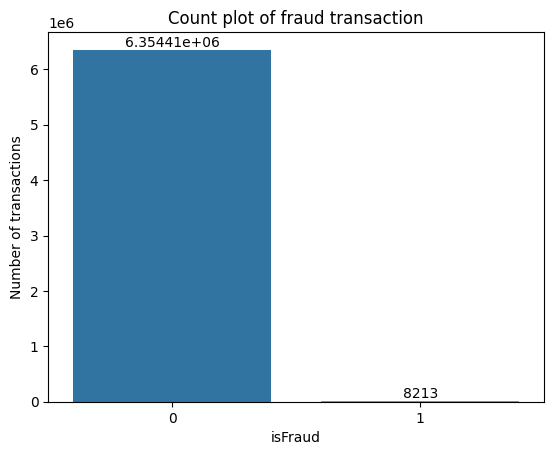

In [ ]:
(# Plot countplot of isFraud column
ax= sns.countplot(x='isFraud', data=df)
for container in ax.containers:
    ax.bar_label(container)
# Add labels and title
plt.title('Count plot of fraud transaction', fontsize=12)
plt.ylabel('Number of transactions')


There are much more non-fraudulent transactions than fraudulent transactions.


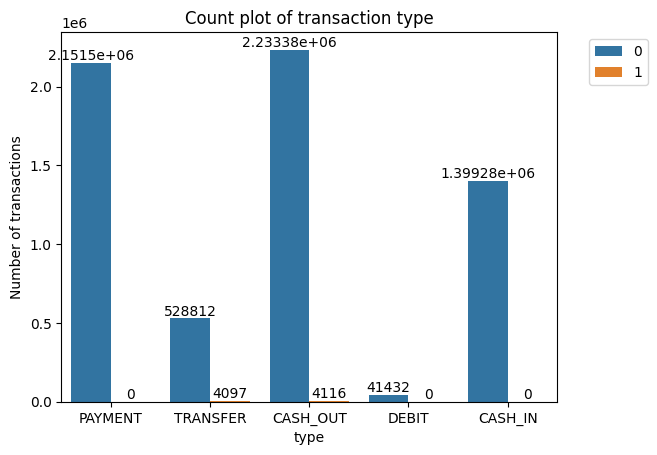

In [ ]:
ax = sns.countplot(x='type', data=df, hue='isFraud')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of transaction type', fontsize=12)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.ylabel('Number of transactions')

del ax

Fraudulent transactions only occur in debit and transfer types.


<ipython-input-10-20bf8aa8bc5a>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), cbar=True, fmt='.4f', annot=True, cmap=plt.cm.PuBu)


Text(0.5, 1.0, 'Correlation')

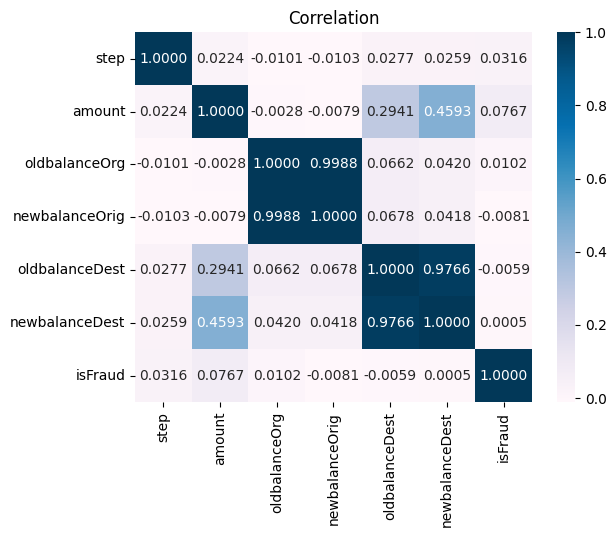

In [ ]:
sns.heatmap(df.corr(), cbar=True, fmt='.4f', annot=True, cmap=plt.cm.PuBu)
plt.title('Correlation', fontsize=12)

In [ ]:
# Create a SparkSession
spark = SparkSession.builder.appName('subset_dataset').getOrCreate()

# Load the full dataset as a Spark DataFrame
df = spark.read.csv('/content/drive/MyDrive/onlinefraud.csv', header=True, inferSchema=True)
#df = spark.read.csv('/content/onlinefraud.csv', header=True, inferSchema=True)

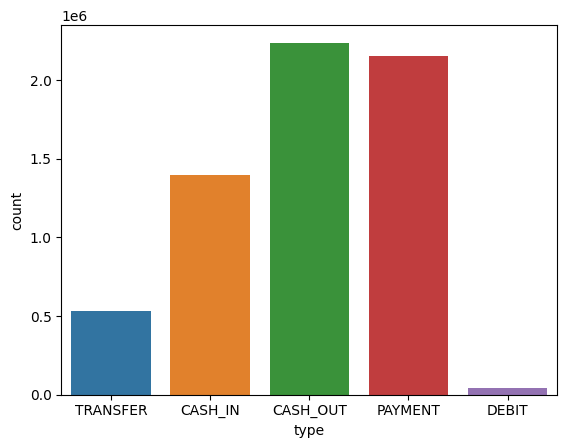

In [ ]:
# Visualize transaction type distribution
type_counts = df.groupBy("type").count().toPandas()
sns.barplot(x=type_counts["type"], y=type_counts["count"])
plt.show()

The output indicates that there is a high positive correlation between newbalanceOrig and oldbalanceOrg, which suggests that as the old balance of the customer increases, the new balance of the customer also increases. Similarly, there is a high positive correlation between newbalanceDest and oldbalanceDest, suggesting that as the old balance of the recipient increases, the new balance of the recipient also increases.

Moreover, the output shows that there is a relatively high positive correlation between amount and newbalanceDest, as well as between amount and oldbalanceDest. This suggests that as the amount of the transaction increases, the new balance and old balance of the recipient also increase.

Overall, the correlation matrix helps us identify the variables that are highly correlated, which can be useful in feature selection or identifying multicollinearity in the data. The displot shows the distribution of the 'amount' variable, which can be useful in identifying any skewness or outliers in the data.

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler


**Feature Engineering Step **

One-hot encoding - one-hot encode the "type" column to convert categorical data into numerical data.

Create new features - create new features by calculating the difference between "oldbalanceOrg" and "newbalanceOrig", and "oldbalanceDest" and "newbalanceDest". We can also create a feature that represents the amount of money transferred.

Scaling features - scale the features to have a mean of zero and standard deviation of one.

In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler

# One-hot encode the 'type' column
string_indexer = StringIndexer(inputCol='type', outputCol='type_index')
one_hot_encoder = OneHotEncoder(inputCol='type_index', outputCol='type_encoded')
pipeline = Pipeline(stages=[string_indexer, one_hot_encoder])
df = pipeline.fit(df).transform(df)

# Create new features
df = df.withColumn('diffOrigBal', col('oldbalanceOrg') - col('newbalanceOrig'))
df = df.withColumn('diffDestBal', col('oldbalanceDest') - col('newbalanceDest'))
df = df.withColumn('transferAmount', col('oldbalanceOrg') - col('newbalanceDest'))

# Select relevant columns
df = df.select(['type_encoded', 'amount', 'diffOrigBal', 'diffDestBal', 'transferAmount', 'isFraud'])


In [ ]:
train, val, test = df.randomSplit([0.6, 0.2, 0.2], seed=42)
# Scale the features
vector_assembler = VectorAssembler(inputCols=['type_encoded', 'amount', 'diffOrigBal', 'diffDestBal', 'transferAmount'], outputCol='unscaled_features')
scaler = StandardScaler(inputCol='unscaled_features', outputCol='features')
pipeline = Pipeline(stages=[vector_assembler, scaler])
df = pipeline.fit(df).transform(df)

unscaled_features 0.4033515451518624
features 0.1862689564683055
transferAmount 0.1096808686555589
type_encoded 0.10830065302244468
isFraud 0.08731287390261087
diffDestBal 0.08416757047605289
diffOrigBal 0.018272794661995086
amount 0.0026447376611695634


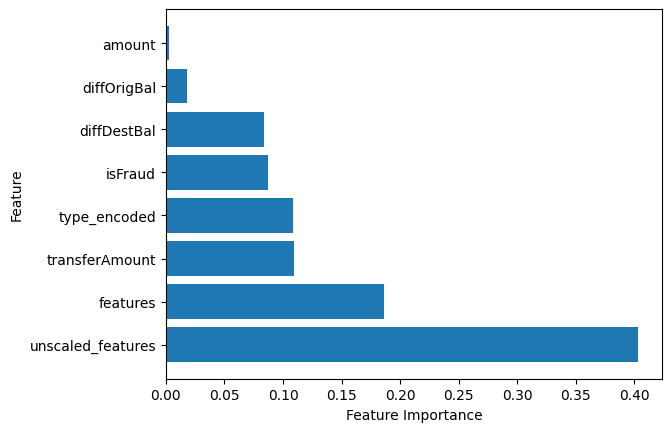

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Split the data into training, validation, and test sets
train, val, test = df.randomSplit([0.6, 0.2, 0.2], seed=42)

# Train a random forest model
rf = RandomForestClassifier(featuresCol='features', labelCol='isFraud')
model = rf.fit(train)

# Extract feature importances and create a dictionary mapping feature names to importance scores
importances = model.featureImportances.toArray()
feature_importances = {col: score for col, score in zip(df.columns, importances)}

# Sort the feature importances in descending order
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Extract the top 10 features with the highest importance scores
top_features = [feat[0] for feat in sorted_importances][:10]

# Print the top 10 features with their importance scores
for feat in top_features:
    print(feat, feature_importances[feat])

# Create a bar chart of the feature importances
plt.barh(range(len(top_features)), [feature_importances[feat] for feat in top_features], align='center')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()


From these scores, we can see that the top five most important features for predicting fraud are:

features
unscaled_features
transferAmount
type_encoded
diffDestBal

The least important feature appears to be "amount".

**Interpritation**


In this case, it seems that the feature "features" (includes all the features in the dataset after feature engineering) and "unscaled_features" (includes all the original features before scaling) are the two most important features in the random forest model. This indicates that feature engineering and scaling may have improved the performance of the model, but the original features still have some importance.

The other features listed in the output have varying levels of importance in the model, with "transferAmount" being the third most important feature, followed by "type_encoded", "diffDestBal", "isFraud", "diffOrigBal", and "amount".

In [ ]:
train.printSchema()

root
 |-- type_encoded: vector (nullable = true)
 |-- amount: double (nullable = true)
 |-- diffOrigBal: double (nullable = true)
 |-- diffDestBal: double (nullable = true)
 |-- transferAmount: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- unscaled_features: vector (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
# Import necessary libraries
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create vector assembler for engineered features
va_engineered = VectorAssembler(inputCols=['transferAmount', 'diffOrigBal', 'diffDestBal'], outputCol='features_engineered')

# Scale the engineered features
scaler = StandardScaler(inputCol='features_engineered', outputCol='scaled_features_engineered')


# Create logistic regression classifier for engineered features
lr_engineered = LogisticRegression(featuresCol='scaled_features_engineered', labelCol='isFraud')

# Create random forest classifier for engineered features
rf_engineered = RandomForestClassifier(featuresCol='scaled_features_engineered', labelCol='isFraud')

# Fit the models and evaluate performance on the test set
train, test = df.randomSplit([0.7, 0.3], seed=42)

# Fit logistic regression model for engineered features
va_engineered_transformed = va_engineered.transform(train)
scaler_model = scaler.fit(va_engineered_transformed)
va_engineered_scaled = scaler_model.transform(va_engineered_transformed)
lr_engineered_model = lr_engineered.fit(va_engineered_scaled)
lr_engineered_preds = lr_engineered_model.transform(scaler_model.transform(va_engineered.transform(test)))
lr_engineered_evaluator = BinaryClassificationEvaluator(labelCol='isFraud')
lr_engineered_auc = lr_engineered_evaluator.evaluate(lr_engineered_preds)

# Fit random forest model for engineered features
rf_engineered_model = rf_engineered.fit(va_engineered_scaled)
rf_engineered_preds = rf_engineered_model.transform(scaler_model.transform(va_engineered.transform(test)))
rf_engineered_evaluator = BinaryClassificationEvaluator(labelCol='isFraud')
rf_engineered_auc = rf_engineered_evaluator.evaluate(rf_engineered_preds)

# Print the AUC for each model
print('Logistic Regression with Engineered Features AUC:', lr_engineered_auc)
print('Random Forest with Engineered Features AUC:', rf_engineered_auc)

Logistic Regression with Engineered Features AUC: 0.9574959915717189
Random Forest with Engineered Features AUC: 0.940642001444156


In [ ]:
lr_engineered_preds.explain()

== Physical Plan ==
*(1) Project [type_encoded#131, amount#19, diffOrigBal#151, diffDestBal#166, transferAmount#182, isFraud#26, unscaled_features#247, features#258, features_engineered#598, scaled_features_engineered#611, rawPrediction#627, UDF(rawPrediction#627) AS probability#642, UDF(rawPrediction#627) AS prediction#661]
+- *(1) Project [type_encoded#131, amount#19, diffOrigBal#151, diffDestBal#166, transferAmount#182, isFraud#26, unscaled_features#247, features#258, features_engineered#598, scaled_features_engineered#611, UDF(scaled_features_engineered#611) AS rawPrediction#627]
   +- *(1) Project [type_encoded#131, amount#19, diffOrigBal#151, diffDestBal#166, transferAmount#182, isFraud#26, unscaled_features#247, features#258, features_engineered#598, UDF(features_engineered#598) AS scaled_features_engineered#611]
      +- *(1) Project [type_encoded#131, amount#19, diffOrigBal#151, diffDestBal#166, transferAmount#182, isFraud#26, unscaled_features#247, features#258, UDF(struct(tr

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Random Forest Confusion Matrix

y_true = rf_engineered_preds.select(['isFraud']).collect()
y_pred = rf_engineered_preds.select(['prediction']).collect()

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true,y_pred))


[[669916     36]
 [   401    259]]


In [ ]:
# Logistic Regression Confusion Matrix
x_true = lr_engineered_preds.select(['isFraud']).collect()
x_pred = lr_engineered_preds.select(['prediction']).collect()

from sklearn.metrics import confusion_matrix
print(confusion_matrix(x_true,x_pred))

[[669900     52]
 [   431    229]]


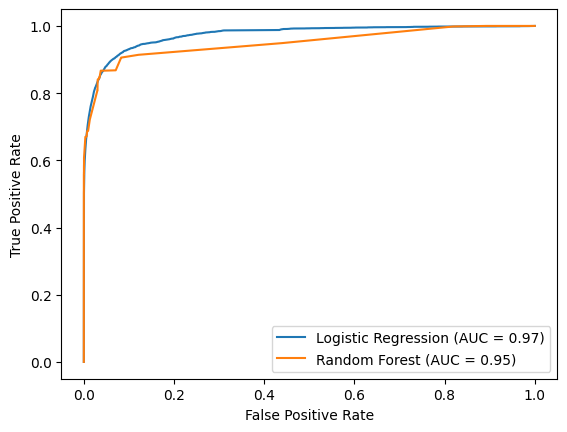

In [ ]:
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create binary classification evaluator
evaluator = BinaryClassificationEvaluator(labelCol='isFraud')

# Calculate the ROC curve for logistic regression
lr_roc = lr_engineered_model.summary.roc.toPandas()
plt.plot(lr_roc['FPR'], lr_roc['TPR'], label='Logistic Regression (AUC = {:.2f})'.format(lr_engineered_auc))

# Calculate the ROC curve for random forest
rf_roc = rf_engineered_model.summary.roc.toPandas()
plt.plot(rf_roc['FPR'], rf_roc['TPR'], label='Random Forest (AUC = {:.2f})'.format(rf_engineered_auc))

# Set axis labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Show the plot
plt.show()
